In [2]:
### Loading packages for analysis/visualization
library(ggplot2)
library(tidyverse)
library(readxl)
library(stringr)
library(dplyr)
library(reshape)
library(lubridate)
library(zoo)
library(MASS)
library(LaplacesDemon)
library(gsynth)
library(doParallel)
library(foreach)
library(forecast)
library(did)
library(data.table)
library(cubelyr)
options(dplyr.summarise.inform = FALSE)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


The following objects are masked from ‘package:tidyr’:

    expand, smiths



Attaching package: ‘lubridate’


The following object is masked from ‘package:reshape’:

    stamp


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘LaplacesDemon’


The follow

In [3]:
sciFormatter <- function(number, digits){ ### Formats numbers in scientific notation, when appropriate

        
    neededNumber <- formatC(number, format = "e", digits = digits)
        
 #   if (str_detect(neededNumber, pattern="e(\\+|-)00$")){
            
  #      neededNumber <- str_replace( neededNumber, pattern="e(\\+|-)00$", replace="")  
            
            
  #  }
        
    return(neededNumber)
        
}

In [4]:
eventTimingAnalysis <- function(Y, Y0, D){
    ### Takes the observed data, an estimated untreated potential outcome matrix,
    ### and a treatment indicator matrix, groups units based on when the adopted the intervention,
    ### and calculates the within-group intervention effect.
    
    allRowSums <- rowSums(D)
    
    uniqueSortedRowSums <- sort(unique(allRowSums), decreasing = F)   
    
    listOfEffects <- list()
    
    for (d in uniqueSortedRowSums[2:(length(uniqueSortedRowSums))]){
        
        theOnesToPull <- allRowSums %in% c(0, d)
        
        YThisDuration <- Y[theOnesToPull,]
        
        Y0ThisDuration <- Y0[theOnesToPull,]
        
        DThisDuration <- D[theOnesToPull, ]
        
        listOfEffects <- c(listOfEffects, list(treat.estimator(Y=YThisDuration, L.hat = Y0ThisDuration, W = DThisDuration)))
        
    }
    
    return(listOfEffects)
    
}

In [5]:
source('../causal_inference_methods_code.R') ## Code for various methodologies

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:reshape’:

    expand


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 3.0-2




In [6]:
max_available_clusters <- detectCores()-1 ### Setting up for parallel processing
  
desired_clusters <- 2
  
cl <- makeCluster(min(c(max_available_clusters, desired_clusters)))

registerDoParallel(cl)

In [7]:
seriesWithUnemploymentDecay <- function(aSeries, finalProp=.96, decayRate=.1, treatmentIndexer){ 
    ### Creates treatment effect for implementation of job retraining
    ### Causes unemployment rate to drop to a proportion of what it would have been
    ### without the program.
    
    if (length(aSeries) != length(treatmentIndexer)){
        
        stop("Series and Treatment Indexer Must be the Same Length.")
    }
    
    if (all(treatmentIndexer==0)){
        
        return(aSeries)
        
    }else{
    
        dataWhereTransformNeeded <- aSeries[treatmentIndexer==1]
    
        transformedPart <- finalProp*dataWhereTransformNeeded+(1-finalProp)*dataWhereTransformNeeded*exp(-1*decayRate*(1:length(dataWhereTransformNeeded)))
        
        aSeries[treatmentIndexer==1] <- transformedPart
        
        return(aSeries)
        
    }
    
}

In [8]:
probFun <- function(r, xBeta){
      
      exp(xBeta+r)/(1+(exp(xBeta+r)))
      
      
    }



meanProbFun <- function(r, xBeta, maxTreatLength, aveTreatDuration){
    
    initialVals <- exp(xBeta+r)/(1+(exp(xBeta+r)))
    
    return(maxTreatLength*mean(initialVals, na.rm=T)-aveTreatDuration)
    
    
}

rFunBin <- function(r, xBeta, C, lengthCutoff){
      
      vals <- (1-probFun(r=r, xBeta=xBeta))^lengthCutoff
      
      return(mean(vals, na.rm=T)-(1-C))
      
    }

# Parameter Read in 

In [9]:
### Reading in various parameters for simulation
simParams <- read.csv('./unemployment_simulation_parameters.csv', row.names = 1,
                     stringsAsFactors=FALSE)

numberOfIterations <- as.numeric(simParams['number_of_iterations', 1])

timeConsidered = as.numeric(simParams['time_considered', 1])
maxTreatLength = as.numeric(simParams['max_treat_length',1])
balanced = as.logical(simParams['balanced', 1])

## simultaneous_adoption, staggered_adoption
design <- simParams['design', 1]

# Unemployment Data Provided by St. Louis Fed

In [17]:
## Unemployment data, Jan 1990-Jan 2011
firstSet <- read_excel('GeoFRED_Unemployment_Rate_by_County_Percent.xls', sheet=1)
colnames(firstSet) <- tolower(str_replace_all(colnames(firstSet), pattern=' ', replace='_'))

## Unemployment data, Feb 2011-Oct 2020
secondSet <- read_excel('GeoFRED_Unemployment_Rate_by_County_Percent.xls', sheet=2)
colnames(secondSet) <- tolower(str_replace_all(colnames(secondSet), pattern=' ', replace='_'))


### Combine the two data sets
fullSet <- (firstSet %>% inner_join(secondSet))

fullSet <- fullSet[!apply(fullSet, MARGIN=1, FUN=function(x) any(is.na(x))), 1:(min(which(str_detect(colnames(fullSet), '2020')))-1)]

justTimeSeriesData <- as.numeric(t(as.matrix(fullSet[4:dim(fullSet)[2]])))

Joining, by = c("series_id", "region_name", "region_code")



In [18]:
### Look for missing values
sum(apply(fullSet, MARGIN=1, FUN=function(x) any(is.na(x))))

[1] 0

In [19]:
allIds <- fullSet[, 1:3] %>% slice(rep(1:n(), each = length(4:dim(fullSet)[2])))

In [20]:
### Convert data from wide to long format, and clean up county names
meltedUnemploymentData <- cbind.data.frame(allIds, justTimeSeriesData)
names(meltedUnemploymentData)[4] <- 'unemployment_rate'
meltedUnemploymentData <- meltedUnemploymentData %>% 
mutate(region_designation=str_extract(region_name, pattern='^.*(?=\\,)'), 
       state=str_extract(region_name, pattern='[A-Z]{2}$'))

In [21]:
timePoints <- seq(1990, 2019+(11/12), 1/12)

In [22]:
seasAdjustGeneral <- function(aSeries, frequency=12){
    ### An automated method for seasonally adjusting many time series at once.
    ### First applies a variance-stabilizing transformation, 
    ### and then seasonally adjusts the series with STL.
    
    aSeries <- ts(aSeries, frequency=frequency)
    
    bestLambda <- BoxCox.lambda(aSeries)
    
    transformedSeries <- BoxCox(aSeries, lambda=bestLambda)
    
    stlDecompTransformedSeries <- stl(transformedSeries, s.window=7)
    
    seasAdjustedSeries <- seasadj(stlDecompTransformedSeries)
    
    finalSeries <- InvBoxCox(seasAdjustedSeries, bestLambda)
    
    return(as.numeric(finalSeries))
    
    
}

In [24]:
### Adding in column for seasonally adjusted series, and removing Alaska/Hawaii from data.
meltedUnemploymentData <- meltedUnemploymentData %>% group_by(region_code) %>% 
mutate(time=timePoints, 
      seasonal_adjust_unemp = seasAdjustGeneral(unemployment_rate, frequency=12)) %>% ungroup()
meltedUnemploymentDataForModeling <- meltedUnemploymentData %>% filter(!(state %in% c('AK', 'HI')))

# Data Exploration and Visualization

In [25]:
alaskaData <- meltedUnemploymentData %>% filter(
                                              state=='AK')

alaskaUnempPlot <- ggplot(alaskaData, aes(x=time, y=seasonal_adjust_unemp, col=region_designation)) + geom_line(lwd=1.5) + 
theme_bw(base_size=20) + ylab('Unemployment Rate (Seasonally Adjusted)') + xlab('Time') +
guides(col=guide_legend(title="County")) + ggtitle("Unemployment in Alaska") 

validSmoothedDataOnly <- meltedUnemploymentDataForModeling  %>% filter(!is.na(seasonal_adjust_unemp))

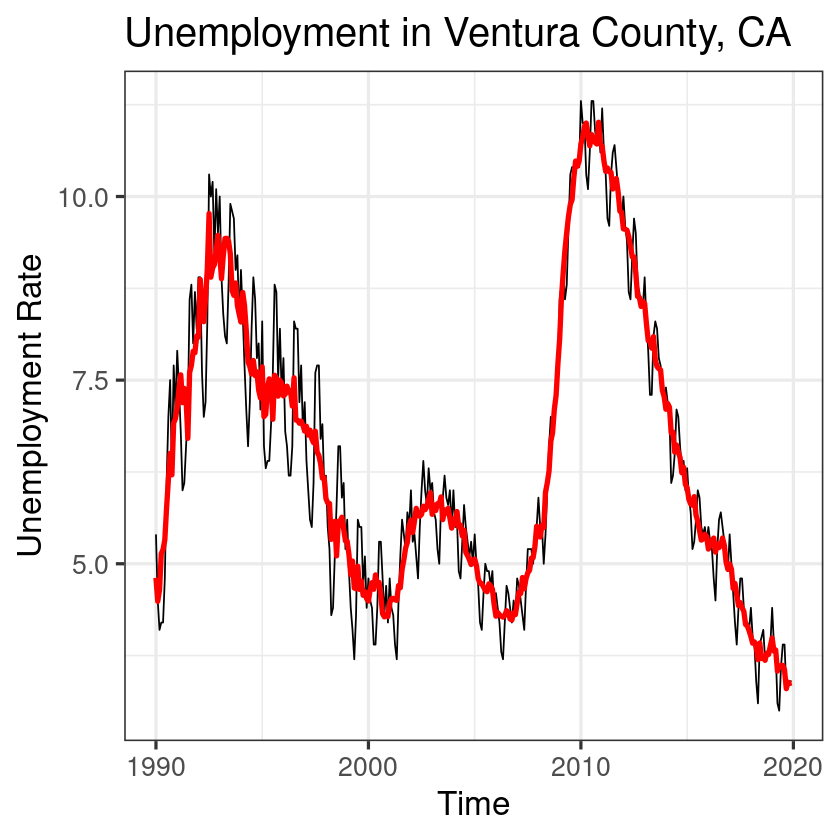

In [41]:
### An example of the unemployment data.
ggplot(aCountyExample, aes(x=time, y=unemployment_rate)) + geom_line() + 
geom_line(aes(x=time, y=seasonal_adjust_unemp), col='red', lwd=1.5) + theme_bw(base_size=20) + 
xlab('Time') + ylab('Unemployment Rate') + ggtitle('Unemployment in Ventura County, CA')

In [21]:
### Formatting smoothed data into wide format, for simulations
fullOutcomeData <- as.matrix(spread(validSmoothedDataOnly[,c('region_code', 'time', 
                    'seasonal_adjust_unemp')], key=c('time'), value='seasonal_adjust_unemp') %>% 
                             column_to_rownames('region_code'))

dimnamesConvention <- dimnames(fullOutcomeData)

names(dimnamesConvention) <- c('region_code', 'time')

In [23]:
unique(table(meltedUnemploymentData$region_code)) ### Verifies all series observed at all time points

[1] 360

In [25]:
### Documented data of various American recessions
recessionDates <- rbind(c("1990-07-01", "1991-03-01"), 
                        c("2001-03-01", "2001-11-01"), 
                        c("2007-12-01", "2009-06-01"))



In [26]:
svdFullOutcome <- svd(fullOutcomeData)

In [27]:
# Computing a low-rank decomposition of the data, and comparing the time series 
# implied by that low-rank structure to the original data. 

rankForDecomp <- 7 ### For comparing a low-rank decomposition of the data to the actual data

centralTerm <- c(svdFullOutcome$d[1:rankForDecomp], rep(0, length(svdFullOutcome$d)-rankForDecomp))

rankRData <- svdFullOutcome$u %*% diag(centralTerm) %*% t(svdFullOutcome$v)

dimnames(rankRData ) <- dimnamesConvention
smoothedUnemploymentData <- as_tibble(as.tbl_cube(rankRData , met='smoothed_unemployment'))



# countiesToPlot <- 'Ventura|San Bernardino|Riverside|Los Angeles|Imperial|San Diego|Santa Barbara|Orange|San Luis Obispo|Kern'

### A plot of unemployment for selected Southern California counties. 
countiesToPlot <- 'Ventura|Riverside|Los Angeles|Orange|San Luis Obispo|Kern'


soCalData <- meltedUnemploymentData %>% filter(str_detect(region_designation, countiesToPlot) &
                                              state=='CA')

soCalData$region_code <- as.numeric(soCalData$region_code)

soCalData <- soCalData %>% inner_join(smoothedUnemploymentData)

socalUnempPlot <- ggplot(soCalData, aes(x=time, y=smoothed_unemployment, col=region_designation)) + geom_line(lwd=1.5) + 
theme_bw(base_size=20) + geom_point(aes(x=time, y=seasonal_adjust_unemp, col=region_designation), size=2) + 
ylab('Unemployment Rate (Seasonally Adjusted)') + xlab('Time') +
guides(col=guide_legend(title="County")) + ggtitle("Unemployment in Southern California")


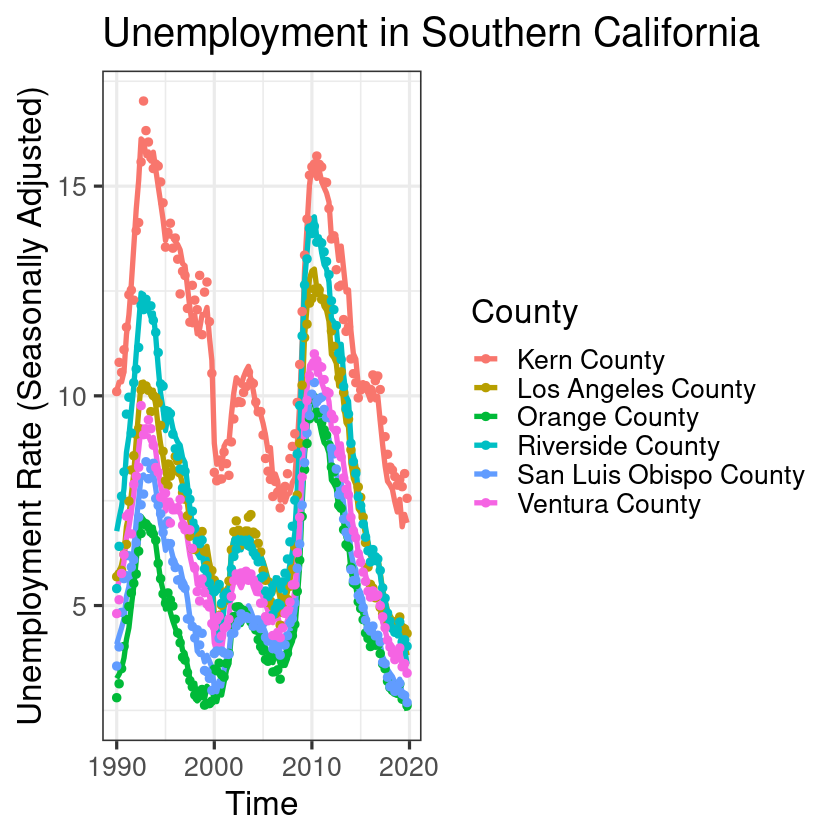

In [29]:
socalUnempPlot 

# Simulations: RMSE Against Proportion of Control Units 

In [31]:
### Average unemployment for each county. Can be used to generate an unbalanced treatment design.
histAves <- rowMeans(fullOutcomeData)

### Various methodologies being compared. 
methodNames <- c('MC-NNM', 'Synthetic Control', 'Synthetic Difference in Differences',
                                     'LAPIS')

valueMatrix <- array(NA, dim=c(4, numberOfIterations),
                         dimnames=c(Method=list(methodNames), Iteration=list(1:numberOfIterations)))

In [32]:
## Whether the estimation target is the average effect for the treated units (set to FALSE),
## or we wish to evaluate performance based on within-group treatment effect estimation (set to TRUE)
eventTimeAnalysis <- FALSE
options(warn=-1)

In [ ]:
valueDataFrames <- list()

compTimeDataFrames <- list()

# seq(.1, .9, .1)

### Proportions of units that adopt the intervention are: .9, .5, .3, .1
for(propTreat in seq(.1, .9, .2)){

    startTime <- Sys.time()
    
    valueMatrix <- array(NA, dim=c(4, numberOfIterations),
                         dimnames=c(Method=list(methodNames), Iteration=list(1:numberOfIterations)))
    
    compTimeMatrix <- array(NA, dim=c(4, numberOfIterations),
                         dimnames=c(Method=list(methodNames), Iteration=list(1:numberOfIterations)))

    for (simNumber in 1:numberOfIterations){ 
        
        
        ### Keeps track of how long each iteration tables
        startTime <- Sys.time()

        ### As the unemployment data set is large, we work with subsamples of the data
        ### to better evaluate each method's effect estimation ability. 
        unitsToSample <- sample(1:dim(fullOutcomeData)[1], size=1000, replace=FALSE)

        fullOutcomeDataSample <- fullOutcomeData[unitsToSample, ]

        ### Number of treated and untreated units is preset
        numberTreat <- floor(dim(fullOutcomeDataSample)[1]*propTreat)

        numberUntreat <- dim(fullOutcomeDataSample)[1]-numberTreat

        ### For a Balanced Treatment Design

        if (balanced){
            ### In a balanced design, there are no unobserved confounders.
            ### This setting can be thought of as having perfect experimental data. 

         if (design=='staggered_adoption'){
             ### For a staggered adoption scenario, a conditional distribution must be set
             ### for how long each unit will adopt the intervention. In the balanced design, 
             ### specifying the marginal duration distribution is sufficient.

            # durations <- c(rep(0, numberUntreat) , rbinom(numberTreat, maxTreatLength, .3))
             
             durations <- c(rep(0, numberUntreat) ,
                            ceiling(runif(numberTreat, 1, maxTreatLength)))

            }else{
             
             ### If the design is a simulataneous adoption design. Units either adopt at the same time point,
             ### or they do not. In this case, the duration distribution is Bernoulli. 

                durations <- maxTreatLength*rbern(dim(fullOutcomeDataSample)[1], p=propTreat) 

         }

         durations <- sample(durations, size=length(durations), replace=FALSE)

            }else{
            #.3*rbeta(1, 3, 1.5)
            
            ### To have an imbalanced design, we allow a unit's average unemployment to be a counfounder.
            
            ### To generate the data, we split the data into two sets, based on a specified quantile. 
            ### Each time, the data below this quantile does not adopt the intervention, and the data 
            ### above this quantile is treated. This way, units that adopt the intervention will have 
            ### higher unemployment rates overall than those that do not adopt the intervention. 
            betaScalar <- .7

            xBetas <- betaScalar*histAves[unitsToSample]

            xBetas[xBetas <= quantile(xBetas, 1-propTreat)] <- -Inf

                   # r <- uniroot(rFunBin, xBeta= xBetas[xBetas != -Inf], C=propTreat,
                   #          lengthCutoff=maxTreatLength,
                   #          lower=-500, upper=500)$root
            
            
            
            ### r allows us to control , on average, how long a treated unit will adopt the intervention for. 
            r <- uniroot(meanProbFun, xBeta= xBetas[!is.infinite(xBetas)], maxTreatLength=maxTreatLength, 
                         aveTreatDuration=20,
                             lower=-500, upper=500)$root

            pis <- probFun(r=r, xBetas)

            if (design=='staggered_adoption'){

          #  durations <- rbinom(length(pis), maxTreatLength, pis)
                
                durations <- ceiling(runif(length(pis), 1, pis*maxTreatLength))

                }else{

               # durations <- 30*rbern(lengths(pis), p=pis)
                
                durations <- maxTreatLength*rep(1, length(pis))
                
                durations[is.infinite(xBetas)] <- 0

            }

        }

        ### Initializing treatment index matrix. 
        ### A cell with a value of 1 is considered "treated"
        ### while a cell with a value of 0 is "untreated"
        D <- array(0, dim=dim(fullOutcomeDataSample))

        dimnames(D) <- dimnames(fullOutcomeDataSample)

        for (i in 1:length(durations)){

            allTimes <- 1:dim(D)[2]

            D[i, dim(D)[2]-durations[i]+1 <= allTimes] <- 1
        }

        timeConsidered <- min(c(timeConsidered, max(rowSums(D))))
        
        
        ### As the effect of the job retraining program is artificially generated, 
        ### we generate the observed data for the simulation from the complete, known untreated potential outcome matrix. 
        observedData <- t(sapply(1:dim(fullOutcomeDataSample)[1], FUN=function(x) 
            seriesWithUnemploymentDecay(aSeries=fullOutcomeDataSample[x,], finalProp=.6, decayRate=.05, 
                                        treatmentIndexer = D[x,])))

        dimnames(observedData) <- dimnames(fullOutcomeDataSample)  
                                
        ### MC-NNM                        
        startTimeMC_NNM <- Sys.time()                        

        mcnnm_info <- matrix_completion_causal(Y=observedData, W=D)     

        mcnnm_est <- treat.estimator(observedData, mcnnm_info$L_hat, D)
                                
        endTimeMC_NNM <- Sys.time() 
                                
        compTimeMC_NNM <- as.numeric(difftime(endTimeMC_NNM, startTimeMC_NNM))
                                
        rankEstimate <- rankMatrix(mcnnm_info$L_hat)
                                
        ### LAPIS
        startTimeLAPIS <- Sys.time()

        lapis_info <- LAPIS(Y=observedData, W=D, rank_threshold = rankEstimate)
                                
        lapis_est <- treat.estimator(observedData, lapis_info, D)
                                
        endTimeLAPIS <- Sys.time()                       
                                
        compTimeLAPIS <- as.numeric(difftime(endTimeLAPIS, startTimeLAPIS))
                                     
        ### Synthetic Control                        
        startTimeSynthCont <- Sys.time()                           

        synthContEst <- synth_cont(Y=observedData, W=D,
                                  return_weighted_average=1-eventTimeAnalysis)
                                
        endTimeSynthCont <- Sys.time()
                                
        compTimeSynthCont <- as.numeric(difftime(endTimeSynthCont, startTimeSynthCont))
                                
        ### Synthetic Difference-in-Differences                        
        startTimeSDID <- Sys.time()  

        SDIDEst <- SDID_general(Y=observedData, W=D,
                         iterations_for_coord_desc=100, return_weighted_average=1-eventTimeAnalysis)
                                
                                
        endTimeSDID <- Sys.time()  
                                
        compTimeSDID <- as.numeric(difftime(endTimeSDID, startTimeSDID))

        trueEffect <- treat.estimator(observedData, fullOutcomeDataSample, D)
        
        ### Errors if doing analysis at group level
        if (eventTimeAnalysis){
            
            mcnnm_est <- eventTimingAnalysis(Y=observedData, Y0=mcnnm_info$L_hat, D=D)
            
            lapis_est <- eventTimingAnalysis(Y=observedData, Y0=lapis_info, D=D)
            
            truth <- eventTimingAnalysis(Y=observedData, Y0=fullOutcomeDataSample, D=D)
            
            onesToPull <- lengths(SDIDEst) <= timeConsidered
            
            ### Retreive the untreated potential outcome matrix that LAPIS implicitly calculates
            
            errorsThisIteration <- c(mean(mapply(mcnnm_est[onesToPull ] , truth[onesToPull], FUN=function(x,y) mean((x-y)^2))), 
                                 mean(mapply(synthContEst[onesToPull ] , truth[onesToPull], FUN=function(x,y) mean((x-y)^2))),
                                 mean(mapply(SDIDEst[onesToPull ] , truth[onesToPull], FUN=function(x,y) mean((x-y)^2))),
                                 mean(mapply(lapis_est[onesToPull ] , truth[onesToPull], FUN=function(x,y) mean((x-y)^2))))

        ### Errors if averaging across groups
        }else{


        errorsThisIteration <- c(mean((mcnnm_est-trueEffect)[1:timeConsidered]^2), 
                                 mean((synthContEst-trueEffect)[1:timeConsidered]^2),
                                 mean((SDIDEst-trueEffect)[1:timeConsidered]^2),
                                 mean((lapis_est-trueEffect)[1:timeConsidered]^2))
            
            }
                                
        compTimesThisIteration <- c(compTimeMC_NNM, compTimeSynthCont, compTimeSDID,
                                  compTimeLAPIS)
                                
        compTimeMatrix[, simNumber] <- compTimesThisIteration


        valueMatrix[ , simNumber] <- errorsThisIteration

        endTime <- Sys.time()
                                
        outMessage <- paste('N0/N: ', 1-propTreat, '; Iteration: ', simNumber, sep='')
      
                                             
     ### Messages used in scripts for keeping track of simulation progress                                        
                                             
     #   print(outMessage)

     #   print(difftime(endTime, startTime, 'mins'))

        }
                                             
                                            
                                             
    ### Formatting simulation results into friendlier format.

    meltedValueMatrix <- as_tibble(as.tbl_cube(valueMatrix, met_name='MSE'))

    meltedValueMatrix$prop_cont <- 1-propTreat
                                
    valueDataFrames <- c(valueDataFrames, list(meltedValueMatrix))
                                
    meltedCompTimeMatrix <- as_tibble(as.tbl_cube(compTimeMatrix, met_name='computation_time_secs'))

    meltedCompTimeMatrix$prop_cont <- 1-propTreat
                                
    compTimeDataFrames <- c(compTimeDataFrames, list(meltedCompTimeMatrix))                                    
                            
    }
                                    

# Results: RMSE Against Proportion of Control Units

In [ ]:
#### Calculates RMSE as a function of the proportion of control units
errorTable <- rbindlist(valueDataFrames)

errorTable$Method <- factor(errorTable$Method, levels=methodNames)


aggErr <- errorTable %>% group_by(Method, prop_cont) %>% summarise(mean_RMSE = mean(sqrt(MSE)))


errorFunctionOfPropUntreat <- ggplot(aggErr, aes(x=prop_cont, y=mean_RMSE, col=Method)) + geom_line(lwd=1.5) + 
theme_bw(base_size=20) + 
xlab('N0/N') + ylab('RMSE')



errorFunctionOfPropUntreatWithUncertainty <- ggplot(errorTable , 
                aes(x=prop_cont, y=sqrt(MSE), col=Method)) + geom_smooth(lwd=1.5) + theme_bw(base_size=20) + 
xlab('N0/N') + ylab('RMSE')

In [ ]:
### Produces LATEX table of RMSE results
aggregatedErrors <- errorTable %>% group_by(Method, prop_cont) %>% dplyr::summarize(RMSE = round(mean(sqrt(MSE), na.rm=T),
                                                                                                  3),
                                               SE = round(sd(sqrt(MSE), na.rm=T)/n(), 3))

aggregatedErrors$`RMSE (SE)` <- paste(aggregatedErrors$RMSE, ' (', aggregatedErrors$SE, ')', sep='')

aggregatedErrors$Method <- factor(aggregatedErrors$Method, levels=methodNames)


aggregatedErrors <- aggregatedErrors[order(aggregatedErrors$Method), ]

tableForLatexRMSE <- aggregatedErrors[, c('Method', 'prop_cont','RMSE (SE)')]

tableForLatexRMSE  <- spread(tableForLatexRMSE , key=c(prop_cont), value=`RMSE (SE)`)

latexRMSETable <- knitr::kable(tableForLatexRMSE, format='latex')

# Results: Computation Time Against Proportion of Control Units

In [ ]:
#### Calculates computation time as a function of the proportion of control units
compTimeTable <- rbindlist(compTimeDataFrames)
aggCompTime <- compTimeTable %>% group_by(Method, prop_cont) %>% summarise(mean_compTime = 
                                                                            mean(computation_time_secs))
compTimeFunctionOfPropUntreat <- ggplot(aggCompTime, aes(x=prop_cont, y=mean_compTime, col=Method)) + geom_line(lwd=1.5) + 
theme_bw(base_size=20) + 
xlab('N0/N') + ylab('Mean Computation Time (Seconds)')


compTimeFunctionOfPropUntreatWithUncertainty <- ggplot(compTimeTable , 
                aes(x=prop_cont, y=computation_time_secs, col=Method)) + geom_smooth(lwd=1.5) + theme_bw(base_size=20) + 
xlab('N0/N') + ylab('Mean Computation Time (Seconds)')

In [ ]:
### Produces LATEX table of comp time results
aggregatedCompTime <- compTimeTable %>% group_by(Method, prop_cont) %>% dplyr::summarize(mean_comp_time = 
                                        round(mean(computation_time_secs, na.rm=T),
                                                                                                  3),
                                               SE = round(sd(computation_time_secs, na.rm=T)/n(), 3))


aggregatedCompTime$`Mean Computation Time (SE), Seconds` <- paste(aggregatedCompTime$mean_comp_time, ' (', 
                                                                  aggregatedErrors$SE, ')', sep='')

aggregatedCompTime$Method <- factor(aggregatedCompTime$Method, levels=methodNames)


aggregatedCompTime <- aggregatedCompTime[order(aggregatedCompTime$Method), ]

tableForLatexCompTime <- aggregatedCompTime[, c('Method', 'prop_cont','Mean Computation Time (SE), Seconds')]

tableForLatexCompTime <- spread(tableForLatexCompTime, key=c(prop_cont), value=`Mean Computation Time (SE), Seconds`)

latexCompTimeTable <- knitr::kable(tableForLatexCompTime, format='latex')

In [ ]:
if (balanced){
    ### Produces a nice visualization of the untreated potential outcome, and the observed data.

    oneYearOfAdoption <- rownames(D)[rowSums(D) >=  min(c(max(rowSums(D)), 12))   ]
    CACountiesThatAdopted <- validSmoothedDataOnly %>% filter(region_code %in% oneYearOfAdoption & state=='CA')

    countyOfInterest <- sample(CACountiesThatAdopted$region_code, 1)




    adoptionTime <- as.numeric(colnames(D)[max(which((D[countyOfInterest, ]==0)))])


    unempVals <- as.numeric(c(observedData[countyOfInterest ,], fullOutcomeData[countyOfInterest, ]))
    times <- as.numeric(rep(colnames(D), 2))

    treatVals <- rep(c("Observed", "Untreated Potential Outcome"), each=dim(D)[2])


    adoptionDataCountyExample <- cbind.data.frame(times, treatVals, unempVals)

    names(adoptionDataCountyExample) <- c('Time', 'Outcome', 'Unemployment')


    adoptionExamplePlot <- ggplot(adoptionDataCountyExample %>% filter(Time >= adoptionTime-36/12), 
                                  aes(x=Time, y=Unemployment, col=Outcome, lty=Outcome)) + 
    geom_line(lwd=2) + theme_bw(base_size=20) + ylab('Unemployment Rate (Seasonally Adjusted)') + xlab('Time') +
     ggtitle("A Successful Retraining Program?") + geom_vline(xintercept = adoptionTime, lwd=1.25) 

}

In [ ]:
if (!balanced){
    ### Produces a plot of average unemployment rate for units that adopt the intervention,
    ### and for units that don't adopt the intervention. 
    ### Only needed in the unbalanced treatment design. 
    
    pretreatmentPeriod <- max(which(colSums(D)==0))

    pretreatmentData <- observedData[, 1:pretreatmentPeriod]

    untreatedData <- colMeans(pretreatmentData[which(rowSums(D)==0),])
    treatedData <- colMeans(pretreatmentData[which(rowSums(D)> 0),])

    groupData <- cbind.data.frame(as.numeric(names(untreatedData), 2), c(rep("Treated", length(treatedData)), 
                       rep('Untreated', length(untreatedData))) , c(treatedData, untreatedData))

    names(groupData) <- c('Time', 'Group', 'Unemployment Rate (Seasonally Adjusted)')

    unemploymentGroupPlot <- ggplot(groupData, aes(x=Time, y=`Unemployment Rate (Seasonally Adjusted)`, col=Group)) + 
    geom_line(lwd=1.5) + theme_bw(base_size=20) + ggtitle('Unemployment by Treatment Group')
    
    }

In [ ]:
### An example of what the marginal duration distribution can look like. 
adoptionDurations <- rowSums(D)
adoptionDistribution <- table(adoptionDurations)
adoptDistData <- cbind.data.frame(as.numeric(names(adoptionDistribution)), as.numeric(adoptionDistribution))

names(adoptDistData) <- c('Duration', 'Count')

adoptDistExamp <- ggplot(adoptDistData, aes(x=Duration, y=log(Count))) + geom_bar(stat="identity",width=.1) + 
geom_point() + theme_bw(base_size=20) + theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) + xlab("Adoption Duration") + ggtitle("Adoption of a Job Retraining Program")

In [ ]:
### Creates output directory for simulation results
plotsAndTablesDir <- paste(paste('./plots_and_tables', c('unbalanced', 'balanced')[balanced+1], sep='_'), 
                           design, sep='/')

if (!exists(plotsAndTablesDir)){
    
    
    dir.create(plotsAndTablesDir, recursive = TRUE)
}

In [ ]:
### Output various plots and tables to simulation result directory. 

ggsave(paste(plotsAndTablesDir,'unemployment_effect.pdf', sep='/'), effectPlot, width=11, height=8.5 )
ggsave(paste(plotsAndTablesDir, 'unemployment_change.pdf', sep='/'), socalUnempPlot, width=11, height=8.5)

if (balanced){
    ggsave(paste(plotsAndTablesDir, 'program_adoption_example.pdf', sep='/'), adoptionExamplePlot, width=11, height=8.5)
    
}

if (!balanced){
    
  ggsave(paste(plotsAndTablesDir, 'unemployment_group_comparison.pdf', sep='/'), 
         unemploymentGroupPlot, width=11, height=8.5)  
    
    
}


errorPlotNames <- paste('error_vs_prop_cont', c('unbalanced', 'balanced')[balanced+1], design, sep='_')
compTimePlotNames <- paste('comp_time_vs_prop_cont', c('unbalanced', 'balanced')[balanced+1], design, sep='_')

ggsave(paste(plotsAndTablesDir,'adoption_curve_example.pdf', sep='/'), adoptDistExamp, width=11, height=8.5)

ggsave(paste(plotsAndTablesDir,paste(errorPlotNames, '.pdf', sep=''), sep='/'), errorFunctionOfPropUntreat, width=11, height=8.5)

ggsave(paste(plotsAndTablesDir,paste(errorPlotNames, '_with_se.pdf', sep=''), sep='/'),
       errorFunctionOfPropUntreatWithUncertainty , width=11, height=8.5)

ggsave(paste(plotsAndTablesDir,paste(compTimePlotNames, '.pdf', sep=''), sep='/'), compTimeFunctionOfPropUntreat, width=11, height=8.5)

ggsave(paste(plotsAndTablesDir,paste(compTimePlotNames, '_with_se.pdf', sep=''), sep='/'),
       compTimeFunctionOfPropUntreatWithUncertainty, width=11, height=8.5)



fileConn<-file(paste(plotsAndTablesDir, paste(errorPlotNames, '_table.txt', sep=''), sep='/'))
writeLines(latexRMSETable, fileConn)
close(fileConn)

fileConn<-file(paste(plotsAndTablesDir, paste(compTimePlotNames, '_table.txt', sep=''), sep='/'))
writeLines(latexCompTimeTable, fileConn)
close(fileConn)

write.table(simParams, paste(plotsAndTablesDir, 'parameter_table.csv', sep='/'))